<a href="https://colab.research.google.com/github/Kwangbin/finance/blob/main/2_%EA%B3%A0%EC%86%8C%EB%93%9D_%EA%B3%A0%EA%B0%9D_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8%EB%A7%81(BlackBox)_%EB%B0%8F_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#shap package install
# 패키지 설치 : optbinning
!pip install optbinning
!pip install shap

     |████████████████████████████████| 195 kB 27.6 MB/s 
     |████████████████████████████████| 178 kB 36.5 MB/s 
     |████████████████████████████████| 14.4 MB 88 kB/s 
     |████████████████████████████████| 28.5 MB 47 kB/s 
  Created wheel for pympler: filename=Pympler-0.9-py3-none-any.whl size=164824 sha256=3a000a2cd50eff3dc6a34cab8b48e6e26a51a85267b568da687eb977d391bf47
  Stored in directory: /root/.cache/pip/wheels/1a/f3/d8/35d5614ea4ddd295ffb9372a5f2f9570d9593d1ea4be33ec6d
  Created wheel for accumulation-tree: filename=accumulation_tree-0.6.2-cp37-cp37m-linux_x86_64.whl size=234411 sha256=6003edd5fc3ad46238cdabaff0cfe1b8da4eb1806ce4723cd97acd80122a80e9
  Stored in directory: /root/.cache/pip/wheels/42/32/0e/08020ae396bf92a3fd00971d0b81a6fb8f3e0681fd8912760d
  Created wheel for pyudorandom: filename=pyudorandom-1.0.0-py3-none-any.whl size=2221 sha256=0509b3af86f05791782dc69d39fd6af6ec7306cb7753395a672f9d82e917902d
  Stored in directory: /root/.cache/pip/wheels/9b/d0/30/b2916c

In [2]:
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#mount google drive

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir(r"/content/drive/MyDrive/ml/kait/finance/dataset/")
import common as cm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# 교차검증 참고자료
# https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608
# 고려개학교 DMQM 랩
# http://dmqm.korea.ac.kr/research/open_courses


import shap
import numpy as np
import pandas as pd

shap.initjs()

#build data set 
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [12]:
#카테고리 타입의 데이터를 인코딩
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [13]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)
print(X_train.shape, X_test.shape)
X_train.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
24029,43.0,6,7.0,2,6,0,4,1,0.0,0.0,60.0,39
8788,18.0,0,10.0,4,0,3,4,0,0.0,1602.0,20.0,39
15564,34.0,4,10.0,4,8,1,4,0,0.0,0.0,40.0,39


In [14]:
#원래 데이터 모양을 위해
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42, stratify=labels_disp)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
24029,43.0,Self-emp-not-inc,7.0,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,0.0,60.0,United-States
8788,18.0,?,10.0,Never-married,?,Own-child,White,Female,0.0,1602.0,20.0,United-States
15564,34.0,Private,10.0,Never-married,Other-service,Not-in-family,White,Female,0.0,0.0,40.0,United-States


In [15]:
# 학습
%%time

import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 8.17 s, sys: 12 ms, total: 8.19 s
Wall time: 8.16 s


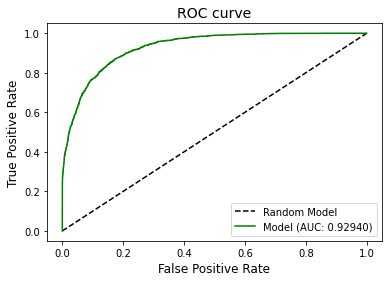

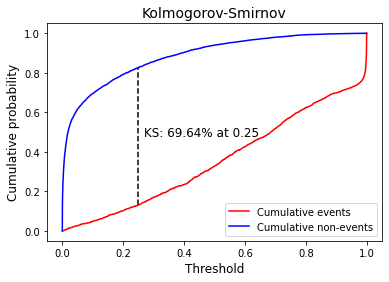

In [16]:
y_pred = xgc.predict_proba(X_test)[:, 1]
plot_auc_roc(y_test, y_pred)
plt.show()
plot_ks(y_test, y_pred)
plt.show()

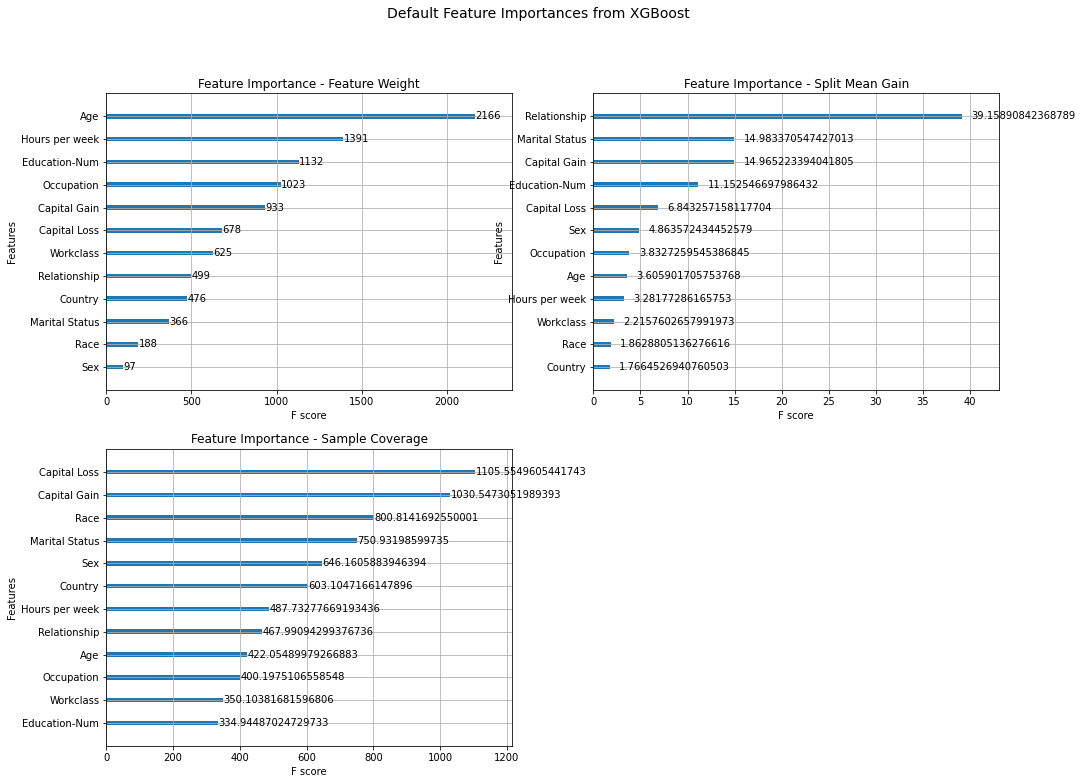

In [17]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

In [18]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head()

Expected Value: -1.3727365


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.480090,-0.040970,-0.374787,0.345022,0.291423,0.599813,0.025128,0.105908,-0.146641,-0.054422,0.045042,0.020798
1,-4.042617,-0.025729,0.121097,0.478994,-0.784796,1.904709,0.010597,-0.173140,-0.134659,-0.076302,-0.967388,-0.018416
2,0.297282,-0.173446,0.620619,-0.428369,0.175841,-0.706941,0.009710,-0.597184,-0.136834,-0.028223,0.163387,-0.000459
3,-0.000913,0.040677,-0.088821,0.353799,-0.496941,0.600724,0.020650,0.094832,-0.156078,-0.057106,0.241312,0.004315
4,0.327123,0.076136,0.711456,0.242046,0.091071,0.663282,0.005766,0.074962,-0.168815,-0.080972,0.239233,0.044418


In [19]:
# 0번 고객

shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test_disp.iloc[0,:])

In [20]:
# 2번 고객
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[2,:], X_test_disp.iloc[2,:])

In [21]:
shap.initjs()

shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], X_test_disp.iloc[:1000,:])

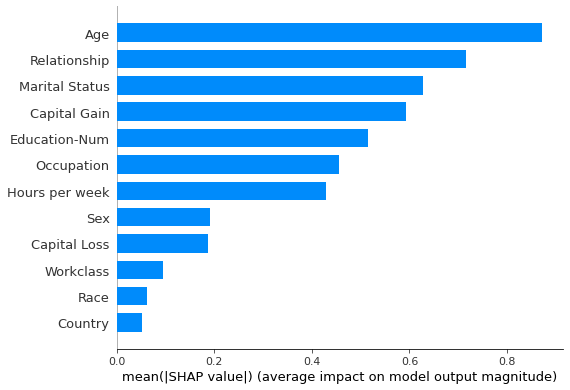

In [22]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

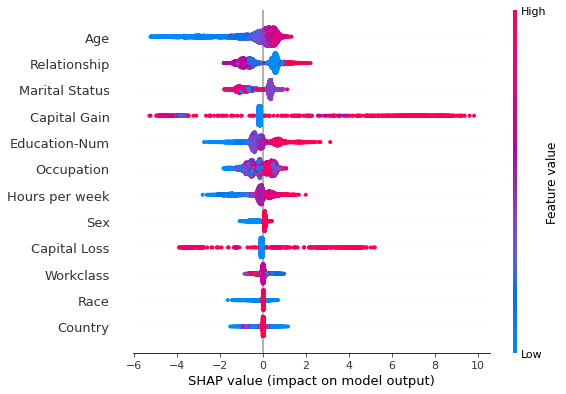

In [23]:
shap.summary_plot(shap_values, X_test)

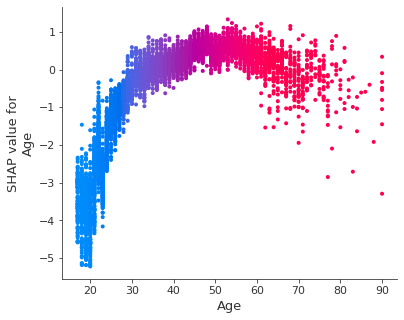

In [24]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

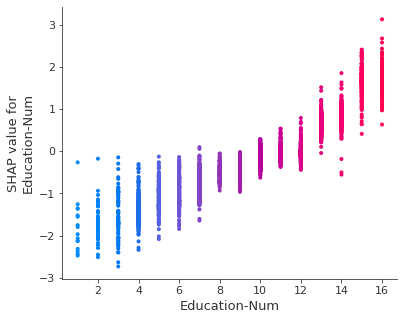

In [27]:
#Education-Num dependence_plot
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

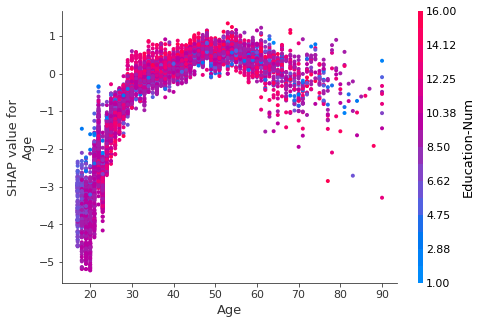

In [28]:
#Education-Num dependence_plot
shap.dependence_plot(ind='Age', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)



2. Optbinning 사용

In [29]:
from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import Counterfactual
from sklearn.linear_model import LogisticRegression

In [32]:
ls

adult.data          common.py  crxdata.data  __pycache__/
bankrupt_data.data  crx.data   crx.names


In [33]:
df = pd.read_csv("adult.data", sep=",", header=None)

columns = ["age", "workclass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex",
           "capital-gain", "capital-loss", "hours-per-week","native-country",
           "income"]

target = "income"

variable_names = ["age", "workclass", "education", "marital-status",
                  "occupation", "race", "sex", "hours-per-week"]

df.columns = columns
df = df[variable_names  + [target]]
df[target] = (df[target].values == ' >50K').astype(int)

df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[target], random_state=42)

In [35]:
df_train

,age,workclass,education,marital-status,occupation,race,sex,hours-per-week,income
24029,43,Self-emp-not-inc,11th,Married-civ-spouse,Handlers-cleaners,White,Male,60,0
8788,18,?,Some-college,Never-married,?,White,Female,20,0
15564,34,Private,Some-college,Never-married,Other-service,White,Female,40,0
9585,17,Private,10th,Never-married,Sales,White,Female,12,0
7377,41,Private,Some-college,Divorced,Other-service,White,Female,36,1
...,...,...,...,...,...,...,...,...,...
28631,40,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Other,Male,40,1
20560,39,Private,Some-college,Divorced,Protective-serv,Black,Female,30,0
23650,55,Private,HS-grad,Married-civ-spouse,Exec-managerial,Asian-Pac-Islander,Male,55,0
25301,26,Private,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,55,0


In [37]:
binning_process = BinningProcess(variable_names)

estimator = LogisticRegression(solver="lbfgs", class_weight="balanced")

scorecard = Scorecard( binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

scorecard.fit(df_train,df_train[target])

Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                         binning_transform_params=None,
                                         categorical_variables=None,
                                         max_bin_size=None, max_n_bins=None,
                                         max_n_prebins=20, max_pvalue=None,
                                         max_pvalue_policy='consecutive',
                                         min_bin_size=None, min_n_bins=None,
                                         min_prebin_size=0.05, n_jobs=None,
                                         selection_criteria=None,
                                         special_codes=None, split_digits=None,
                                         v...
          estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                       dual=False, fit_intercept=True,
                                       intercept_scaling=1, l1_ratio=None,
    

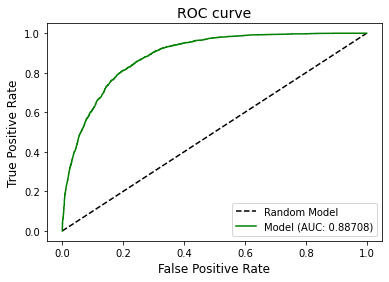

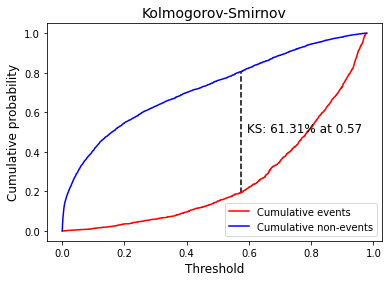

In [38]:
y_pred = scorecard.predict_proba(df_test)[:, 1]
plot_auc_roc(df_test[target], y_pred)
plt.show()
plot_ks(df_test[target], y_pred)
plt.show()

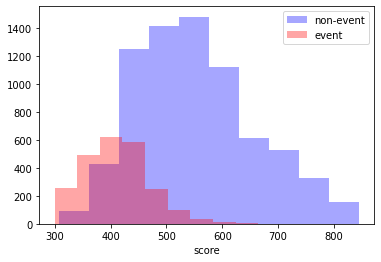

In [39]:
score = scorecard.score(df_test)
mask = df_test[target] == 0
plt.hist(score[mask], label="non-event", color="b", alpha=0.35)
plt.hist(score[~mask], label="event", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

In [40]:
idx_lowest = np.argmin(scorecard.predict_proba(df)[:, 1])
query = df.iloc[idx_lowest, :-1].to_dict()

In [41]:
query

{'age': 17,
 'education': ' 11th',
 'hours-per-week': 25,
 'marital-status': ' Never-married',
 'occupation': ' Other-service',
 'race': ' Black',
 'sex': ' Female',
 'workclass': ' Private'}

In [42]:
cf = Counterfactual(scorecard=scorecard)
cf.fit(df)

Counterfactual(n_jobs=1,
               scorecard=Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                                                  binning_transform_params=None,
                                                                  categorical_variables=None,
                                                                  max_bin_size=None,
                                                                  max_n_bins=None,
                                                                  max_n_prebins=20,
                                                                  max_pvalue=None,
                                                                  max_pvalue_policy='consecutive',
                                                                  min_bin_size=None,
                                                                  min_n_bins=None,
                                                                  min_prebin_size=0.05,
   

In [43]:
cf.generate(query=query, y=1, outcome_type="binary", n_cf=1, max_changes=3)

Counterfactual(n_jobs=1,
               scorecard=Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                                                  binning_transform_params=None,
                                                                  categorical_variables=None,
                                                                  max_bin_size=None,
                                                                  max_n_bins=None,
                                                                  max_n_prebins=20,
                                                                  max_pvalue=None,
                                                                  max_pvalue_policy='consecutive',
                                                                  min_bin_size=None,
                                                                  min_n_bins=None,
                                                                  min_prebin_size=0.05,
   

In [44]:
cf.status

'OPTIMAL'

In [45]:
cf.information(print_level=2)

optbinning (Version 0.12.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    scorecard                            yes   * U
    special_missing                    False   * d
    n_jobs                                 1   * d
    verbose                            False   * d
  End options

  Status  : OPTIMAL                         

  Solver statistics
    Type                                 mip
    Number of variables                   89
    Number of constraints                 42
    Objective value                  16.0845
    Best objective bound             16.0845

  Objectives
    proximity                         3.7543
    closeness                        12.3302

  Timing
    Total time                          0.19 sec
    Fit                                 0.09 sec   ( 46.64%)
    Solver                              0.09 sec   ( 50.53%)
    Post-processing                     0.01 sec   (  5.61%)



In [46]:
cf.display(show_only_changes=True, show_outcome=True)

,age,workclass,education,marital-status,occupation,race,sex,hours-per-week,outcome
0,"[33.50, 36.50)",-,"[ Masters, Doctorate, Prof-school]","[ Married-AF-spouse, Married-civ-spouse]",-,-,-,-,0.521575
